<a href="https://colab.research.google.com/github/Naveenand/Natural-Language-Processing/blob/main/sentiment_analysis_with_bert_and_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 kaggle.json

In [ ]:
!kaggle datasets download -d sbhatti/financial-sentiment-analysis

  0% 0.00/276k [00:00<?, ?B/s]
100% 276k/276k [00:00<00:00, 120MB/s]


In [ ]:
!unzip /content/financial-sentiment-analysis.zip

Archive:  /content/financial-sentiment-analysis.zip
  inflating: data.csv                


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.5 MB/s eta 0:00:00


In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from tqdm.auto import tqdm
import string
#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

In [ ]:
#Read in data
df = pd.read_csv('/content/data.csv')

In [ ]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
print(df.shape)

(5842, 2)


<Axes: >

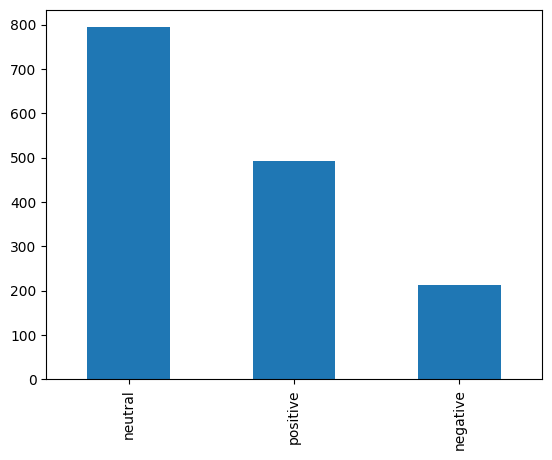

In [ ]:
df['Sentiment'][:1500].value_counts().plot.bar()

In [ ]:
# Divide the dataset into three separate DataFrames based on sentiment
positive_df = df[df['Sentiment'] == 'positive'][0:500]
negative_df = df[df['Sentiment'] == 'negative'][:500]
neutral_df = df[df['Sentiment'] == 'neutral'][:500]

# Concatenate the three DataFrames
concatenated_df = pd.concat([positive_df, negative_df, neutral_df], ignore_index=True)

# Shuffle the concatenated DataFrame
df = concatenated_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df.shape

(1500, 2)

#Data preprocessing

In [ ]:
df['Sentence'] = df['Sentence'].apply(lambda x: x.lower())
df.head(1)

,Sentence,Sentiment
0,"however , the offering will probably not be ma...",neutral


In [ ]:
df['Sentence'] = df['Sentence'].apply(lambda x: contractions.fix(x))

In [ ]:
def remove_punctuation(text):
    # Define a translation table to remove punctuation
    translator = str.maketrans('', '', string.punctuation)

    # Remove punctuation from the text
    text = text.translate(translator)

    return text

In [ ]:
df['Sentence'] = df['Sentence'].apply(remove_punctuation)

In [ ]:
sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "jan": "january",
    "feb": "february",
    "mar": "march",
    "apr": "april",
    "may": "may",
    "jun": "june",
    "jul": "july",
    "aug": "august",
    "sep": "september",
    "oct": "october",
    "nov": "november",
    "dec": "december"
 }

def replace_symbols_short_form(text):
    for symbol, word in sample_abbr.items():
        text = text.replace(symbol, word)
    return text

df['Sentence'] = df['Sentence'].apply(replace_symbols_short_form)

In [ ]:
# Removing stopwords.
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Sentence,Sentiment
0,however offering probably made current valuati...,neutral
1,intercontinental hotels denies reports starwoo...,neutral
2,according company updated strategy years 20092...,positive
3,metsaliitto said book minor gain less eur1 0 t...,positive
4,scania morgan stanley lifted share target swed...,positive


In [ ]:
text_len = []
for text in df['Sentence']:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
token_lens = []

for txt in df['Sentence'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 66


In [ ]:
df['token_lens'] = token_lens

In [ ]:
df = df.sort_values(by='token_lens', ascending=False)
df.head()

,Sentence,Sentiment,text_len,token_lens
1194,alma media corporation press release 15 marchc...,neutral,28,66
933,1 pm central office nordea bank 19 3ya ulitsa ...,neutral,33,63
190,2009 3 februaryruary 2010 finlandbased steel m...,negative,25,55
1227,adpnews february 3 2010 finlandbased steel mak...,neutral,26,51
230,name applicant jot automation oyname inventor ...,neutral,19,51


In [ ]:
df.head(1)

,Sentence,Sentiment,text_len,token_lens
1194,alma media corporation press release 15 marchc...,neutral,28,66


In [ ]:
label_mapping = {
    "positive": 1,
    "neutral": 0,
    "negative": 2
}

df['Sentiment'] = df['Sentiment'].map(label_mapping)

In [ ]:
df.head()

,Sentence,Sentiment,text_len,token_lens
1194,alma media corporation press release 15 marchc...,0,28,66
933,1 pm central office nordea bank 19 3ya ulitsa ...,0,33,63
190,2009 3 februaryruary 2010 finlandbased steel m...,2,25,55
1227,adpnews february 3 2010 finlandbased steel mak...,0,26,51
230,name applicant jot automation oyname inventor ...,0,19,51


In [ ]:
x = df['Sentence'].values
y = df['Sentiment'].values

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y, random_state= 42)

In [ ]:
x_valid, x_test, y_valid, y_test = train_test_split(x_valid,y_valid, test_size = 0.5, stratify = y_valid, random_state = 42)

In [ ]:
print('the x_train shape:', x_train.shape)
print('the x_valid shape:', x_valid.shape)
print('the x_test shape:', x_test.shape)

the x_train shape: (1200,)
the x_valid shape: (150,)
the x_test shape: (150,)


In [ ]:
x_cv = clf.fit_transform(x)

In [ ]:
x_cv.shape[1]

5704

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_cv, y, test_size=0.2, stratify=y, random_state= 42)

In [ ]:
x_valid, x_test, y_valid, y_test = train_test_split(x_valid,y_valid, test_size = 0.5, stratify = y_valid, random_state = 42)

#Naive Bayes Classifier

In [ ]:
clf = CountVectorizer()
x_train_cv =  clf.fit_transform(x_train)
x_valid_cv = clf.fit_transform(x_valid)
x_test_cv = clf.transform(x_test)

In [ ]:
x_train_cv.shape[1]

5005

In [ ]:
x_valid_cv

<150x1133 sparse matrix of type '<class 'numpy.int64'>'
	with 1759 stored elements in Compressed Sparse Row format>

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(x_train)
x_train_tf = tf_transformer.transform(x_train)
x_valid_tf = tf_transformer.transform(x_valid)
x_test_tf = tf_transformer.transform(x_test)

In [ ]:
nb_clf = MultinomialNB()

In [ ]:
nb_clf.fit(x_train_tf, y_train)

MultinomialNB()

In [ ]:
nb_pred = nb_clf.predict(x_test_tf)

In [ ]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.62      0.60      0.61        50
     Neutral       0.64      0.54      0.59        50
    Positive       0.60      0.72      0.65        50

    accuracy                           0.62       150
   macro avg       0.62      0.62      0.62       150
weighted avg       0.62      0.62      0.62       150



#Bert Sentiment Analysis

In [ ]:
MAX_LEN=128

In [ ]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize(x_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(x_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(x_test, MAX_LEN)

In [ ]:
train_input_ids.shape

(1200, 128)

In [ ]:
train_attention_masks.shape


(1200, 128)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
#keras
import tensorflow as tf
from tensorflow import keras

#Bert Modeling


In [ ]:
def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)


    return model

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_3[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_4[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
38/38 [==============================] - 55s 952ms/step - loss: 1.0855 - sparse_categorical_accuracy: 0.4017 - val_loss: 1.0561 - val_sparse_categorical_accuracy: 0.4267
Epoch 2/4
38/38 [==============================] - 32s 843ms/step - loss: 0.9224 - sparse_categorical_accuracy: 0.5633 - val_loss: 0.9179 - val_sparse_categorical_accuracy: 0.5867
Epoch 3/4
38/38 [==============================] - 31s 829ms/step - loss: 0.7343 - sparse_categorical_accuracy: 0.6958 - val_loss: 0.8762 - val_sparse_categorical_accuracy: 0.6200
Epoch 4/4
38/38 [==============================] - 30s 800ms/step - loss: 0.5372 - sparse_categorical_accuracy: 0.7883 - val_loss: 0.8367 - val_sparse_categorical_accuracy: 0.6467


In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])

5/5 [==============================] - 5s 255ms/step


In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,result_bert.argmax(axis = 1), target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.68      0.72      0.70        50
     Neutral       0.76      0.64      0.70        50
    Positive       0.69      0.76      0.72        50

    accuracy                           0.71       150
   macro avg       0.71      0.71      0.71       150
weighted avg       0.71      0.71      0.71       150



#RoBERTa Sentiment Analysis


In [ ]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

In [ ]:
token_lens = []

for txt in x_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

65

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize_roberta(x_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(x_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(x_test, MAX_LEN)

#RoBERTa Modeling

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [ ]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model_1 (TFRobe  TFBaseModelOutputWithPooli   1246456   ['input_1[0][0]',             
 rtaModel)                   ngAndCrossAttentions(last_   32         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [ ]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)

Epoch 1/4
40/40 [==============================] - 46s 748ms/step - loss: 1.0912 - sparse_categorical_accuracy: 0.3950 - val_loss: 1.0464 - val_sparse_categorical_accuracy: 0.5533
Epoch 2/4
40/40 [==============================] - 28s 705ms/step - loss: 0.8545 - sparse_categorical_accuracy: 0.6058 - val_loss: 0.9697 - val_sparse_categorical_accuracy: 0.6067
Epoch 3/4
40/40 [==============================] - 29s 720ms/step - loss: 0.5599 - sparse_categorical_accuracy: 0.7725 - val_loss: 0.8282 - val_sparse_categorical_accuracy: 0.6333
Epoch 4/4
40/40 [==============================] - 30s 745ms/step - loss: 0.4264 - sparse_categorical_accuracy: 0.8383 - val_loss: 0.9524 - val_sparse_categorical_accuracy: 0.6800


In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

5/5 [==============================] - 1s 249ms/step


In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,result_roberta.argmax(axis = 1), target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.80      0.70      0.74        50
     Neutral       0.77      0.74      0.76        50
    Positive       0.74      0.86      0.80        50

    accuracy                           0.77       150
   macro avg       0.77      0.77      0.77       150
weighted avg       0.77      0.77      0.77       150

